<a href="https://colab.research.google.com/github/rprentice33/EM_data_viewer/blob/main/PINN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GP248CME215/PINN_tf2/blob/main/Burgers_equation_25_spring_TF2.ipynb)





In [ ]:
##############################################################################################################
# RUN THIS CODE BLOCK FIRST, it will load dependencies / install them if your system does not already have them.
##############################################################################################################

# tensorflow
try:
    # Try to import TensorFlow
    import tensorflow as tf
    print(f"TensorFlow is already installed. Version: {tf.__version__}")
except ImportError as e:
    # TensorFlow is not installed; install it
    print("TensorFlow is not installed. Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"Successfully installed TensorFlow. Version: {tf.__version__}")

# pyDOE
try:
    # Try to import pyDOE
    import pyDOE
    print(f"pyDOE is already installed.")
except ImportError as e:
    # pyDOE is not installed; install it
    print("pyDOE is not installed. Installing pyDOE...")
    !pip install pyDOE
    import pyDOE
    print(f"Successfully installed pyDOE.")


"""
@author: Yongji Wang, Yao Lai, Ray Chou (modified from Maziar Raissi)
"""
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(123)
tf.random.set_seed(123)

print(tf.__version__)

TensorFlow is already installed. Version: 2.18.0
pyDOE is not installed. Installing pyDOE...
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=111bb10ae8c8d1d5ea1dc2aeb08b2abdce2e8aedc9d40fb55c783eb3a91c57f2
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
2.18.0


In [ ]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  folderpath = "/content/drive/My Drive/Colab Notebooks/data/"
  x = np.load(folderpath + "x.npy")
  y = np.load(folderpath + "y.npy")
  z = np.load(folderpath + "z.npy")
  res = np.load(folderpath + "res.npy")
  data_pc = np.load(folderpath + "pc_CPT.npy")
  ind_data = np.load(folderpath + "ind_CPT.npy")
  xgrid = np.load(folderpath + "x_grid.npy")
  ygrid = np.load(folderpath + "y_grid.npy")
  zgrid = np.load(folderpath + "z_grid.npy")
  resgrid = np.load(folderpath + "res_grid.npy")
  ind_grid = np.load(folderpath + "ind_grid.npy")

# Neural Network Implementation

In [ ]:
min_coarse, max_coarse = 1, 150
min_fine, max_fine = 1, 25

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_test, u_test, X_f, layers, lb, ub, nu):
        # Domain bounds for input normalization
        self.lb = lb
        self.ub = ub

        # Split supervised data inputs (with known solution u) into x and t
        self.x_u = X_u[:, 0:1]
        self.y_u = X_u[:, 1:2]
        self.z_u = X_u[:, 2:3]
        self.saline_u = X_u[:, 3:4]
        self.rho_u = X_u[:, 4:5]

        #split tests data inputs
        self.x_test = X_test[:, 0:1]
        self.y_test = X_test[:, 1:2]
        self.z_test = X_test[:, 2:3]
        self.saline_test = X_test[:, 3:4]
        self.rho_test = X_test[:, 4:5]





        # Split collocation points (where PDE is enforced) into x and t
        self.x_f = X_f[:, 0:1]
        self.y_f = X_f[:, 1:2]
        self.z_f = X_f[:, 2:3]
        self.saline_f = X_f[:, 3:4]
        self.rho_f = X_f[:, 4:5]


        # Known solution at supervised points
        self.u = u

        #Known solution at test points
        self.u_test = u_test

        # Network architecture and PDE parameter
        self.layers = layers
        self.nu = nu

        # Initialize neural network weights and biases
        self.weights, self.biases = self.initialize_NN(layers)

        # All trainable parameters for optimization
        self.train_variables = self.weights + self.biases
        # These are tf.Variable objects so updates here affect the model directly

        # Initialize loss (this is not necessary here but allows pre-evaluation)
        self.loss = self.loss_NN()

    '''
    Neural Network Initialization Functions
    =======================================
    '''

    def initialize_NN(self, layers):
        # Initialize weights and biases for each layer using Xavier init
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        # Xavier/Glorot initialization to avoid vanishing/exploding gradients
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        # Forward pass through the fully connected feedforward neural network
        num_layers = len(weights) + 1

        # Normalize inputs to [-1, 1] using domain bounds
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        #H = H[:,0:4]

        # Hidden layers with tanh activation
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            #H = tf.keras.activations.sigmoid(tf.add(tf.matmul(H, W), b))
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        # Output layer (sigmoid activation)
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        Y = tf.keras.activations.sigmoid(Y)
        return Y

    '''
    Physics-Informed PDE Modeling
    =============================
    '''

    def net_u(self, x, y, z, saline, rho):
        # Predict u(x, t) by feeding concatenated input into the network
        u = self.neural_net(tf.concat([x, y, z, saline, rho], 1), self.weights, self.biases)
        return u


    @tf.function
    def loss_NN(self):
        # Compute the total loss: data loss + PDE residual loss
        # Prediction of u at supervised data points
        self.u_pred = self.net_u(self.x_u, self.y_u, self.z_u, self.saline_u, self.rho_u)

        rhoc, rhof =  min_coarse+(max_coarse-min_coarse)*self.u_pred[:,1], min_fine+(max_fine-min_fine)*self.u_pred[:,0]
        rho = tf.reshape(tf.cast(rho_data_train, dtype=tf.float32), [-1])
        rhof = tf.reshape(rhof, [-1])  # Reshape to (220,)
        rhoc = tf.reshape(rhoc, [-1])  # Reshape to (220,)
        pc_physics = tf.ones_like(rho, dtype=tf.float32)

        pc_physics = tf.where(rho < rhof, tf.zeros_like(rho), pc_physics)
        pc_physics = tf.where(tf.logical_and(rho >= rhof, rho < rhoc) , (rhoc*rhof/rho-rhoc)*1/(rhof-rhoc), pc_physics)

        self.u_pred = pc_physics

        #loss coarse > fine
        loss_cf = rhof-rhoc
        loss_cf = tf.where(loss_cf < 0, tf.zeros_like(loss_cf), loss_cf)
        loss_cf = tf.reduce_mean(loss_cf)

        # Mean squared error between predicted and known u
        loss = tf.reduce_mean(tf.square(self.u - self.u_pred))

        # L2 regularization loss
        l2_loss = tf.add_n([tf.nn.l2_loss(W) for W in self.weights])
        l2_loss *= 5e-4


        # Total loss = data loss + physics loss (unweighted here)
        return loss + loss_cf +l2_loss

    def loss_NN_test(self):
      self.u_pred_test = self.net_u(self.x_test, self.y_test, self.z_test, self.saline_test, self.rho_test)

      rhoc, rhof =  min_coarse+(max_coarse-min_coarse)*self.u_pred_test[:,1], min_fine+(max_fine-min_fine)*self.u_pred_test[:,0]
      rho = tf.reshape(tf.cast(rho_data_test, dtype=tf.float32), [-1])
      rhof = tf.reshape(rhof, [-1])
      rhoc = tf.reshape(rhoc, [-1])
      pc_physics = tf.ones_like(rho, dtype=tf.float32)

      pc_physics = tf.where(rho < rhof, tf.zeros_like(rho), pc_physics)
      pc_physics = tf.where(tf.logical_and(rho >= rhof, rho < rhoc) , (rhoc*rhof/rho-rhoc)*1/(rhof-rhoc), pc_physics)

      self.u_pred_test = pc_physics

      loss = tf.reduce_mean(tf.square(self.u_test - self.u_pred_test))
      return loss




    def train(self, nIter: int, learning_rate: float):
        """
        Train the model using Adam optimizer and gradient clipping.
        Uses exponential decay learning rate and logs progress every 100 iterations.
        """
        # Exponential learning rate decay, to help release the issue of training loss oscilation
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=200,
            decay_rate=.9
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=5e-4)

        varlist = self.weights + self.biases  # All trainable variables

        # Logging variables
        start_time = time.time()
        it_list = []
        loss_list = []
        loss_test_list = []

        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss = self.loss_NN()
            # Compute gradients of loss w.r.t. weights and biases
            grads = tape.gradient(loss, varlist)
            test_loss = self.loss_NN_test()

            # Optional: clip gradients to prevent exploding updates
            clipped_grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]

            # Apply gradients to update model parameters
            optimizer.apply_gradients(zip(clipped_grads, varlist))

            # Logging
            it_list.append(it)
            loss_list.append(loss)
            loss_test_list.append(test_loss)

            if (it + 1) % 100 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' % (it, loss.numpy(), test_loss.numpy(), elapsed))
                start_time = time.time()

        return it_list, loss_list, loss_test_list

    @tf.function
    def predict(self, X_star):
        # Evaluate the trained model: predict both u and f at new points
        u_star = self.net_u(X_star[:, 0:1], X_star[:, 1:2], X_star[:, 2:3], X_star[:, 3:4], X_star[:, 4:5])
        #f_star = self.net_f(X_star[:, 0:1], X_star[:, 1:2], X_star[:, 2:3], X_star[:, 3:4], X_star[:, 4:5], self.u)
        f_star = u_star
        return u_star, f_star


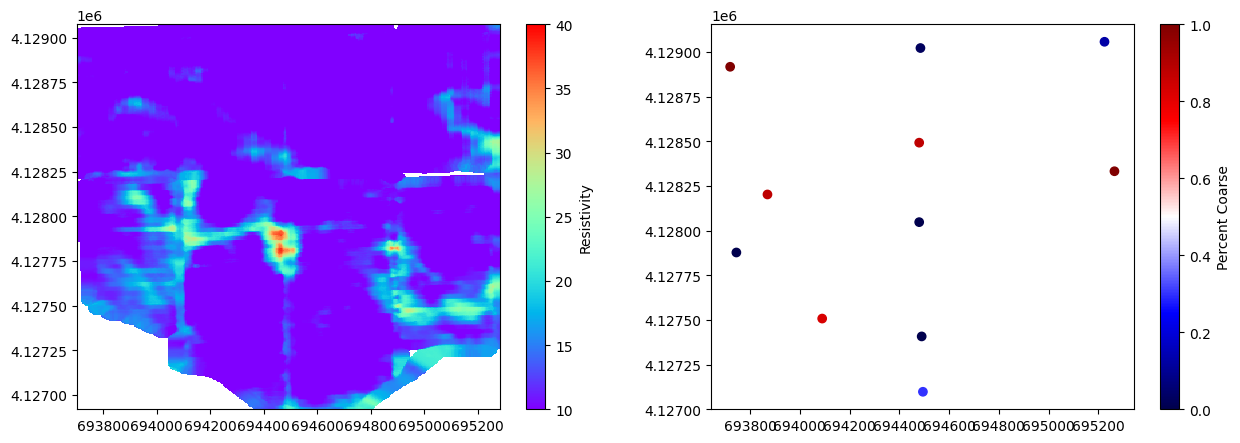

In [ ]:

# Plot resistivity and sediment type data at a depth layer
depth_layer = 7
x_data, y_data, z_data, rho_data = x[ind_data], y[ind_data], z[ind_data], res[ind_data]
ind_data_plot = z_data==depth_layer
ind_data_plot = ind_data_plot[:,0]

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.pcolormesh(xgrid[:,:,depth_layer], ygrid[:,:,depth_layer],resgrid[:,:,depth_layer], cmap = 'rainbow', vmin = 10, vmax = 40)
plt.colorbar(label = "Resistivity")

plt.subplot(122)
plt.scatter(x_data[ind_data_plot], y_data[ind_data_plot], c = data_pc[ind_data_plot], cmap = 'seismic')
plt.colorbar(label = "Percent Coarse")

In [ ]:
# get data to train the model
nu = 0.01/np.pi
train_ratio = 0.9
n_data = len(rho_data)

seed = 0
np.random.seed(seed)

indices = np.arange(n_data)
np.random.shuffle(indices)
n_train = int(train_ratio * n_data)
train_indices = indices[:n_train]
test_indices = indices[n_train:]



n = len(x)
saline =2*np.ones_like(res)
saline[res<6] = 0
saline[(res>2)&(res<4)] = 1
X_all = np.hstack((x.reshape([n,1]), y.reshape([n,1]), z.reshape([n,1]) , saline.reshape([n,1]), res.reshape([n,1])))

saline_data =2*np.ones_like(rho_data)
saline_data[rho_data<6] = 0
saline_data[(rho_data>2)&(rho_data<4)] = 1
X_star = np.hstack((x_data,y_data,z_data, saline_data, rho_data))  # dimension of 25600 x 2
u_star = data_pc                        # dimension of 25600 x 1

# Domain bounds
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)


N_f = 1000
idx = np.random.choice(X_all.shape[0], N_f, replace=False)
idx = np.append(idx, ind_data)
X_f_train = X_all[idx]
X_f_train = X_f_train[~np.isnan(res[idx])]


X_u_train = X_star[train_indices]
u_train = u_star[train_indices]
rho_data_train = rho_data[train_indices]
rho_data_test = rho_data[test_indices]
X_u_test = X_star[test_indices]
u_test = u_star[test_indices]



X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)
X_u_test = tf.cast(X_u_test, dtype=tf.float32)
u_test = tf.cast(u_test, dtype=tf.float32)

# NN initialization and Training!
This might take a few minutes

In [ ]:
layers = [5, 10, 10, 10, 2]
model = PhysicsInformedNN(X_u_train, u_train, X_u_test, u_test, X_f_train, layers, lb, ub, nu)

start_time = time.time()
it_list, loss_list, test_loss_list = model.train(10000, learning_rate=1e-2)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

### Note, here we only require you to train 5k iterations, which is sufficient for this P-set.
### If you don't exactly match what Figure 1 (Pset2 pdf) shows, it is totally fine as it takes more iterations and time to train,
### and we are not asking you to fully reproduce the figure 100%. But you are supposed to get something
### close to it.

It: 99, Train Loss: 9.556e-02, Test Loss: 1.489e-01, Time: 6.84
It: 199, Train Loss: 8.118e-02, Test Loss: 1.678e-01, Time: 7.15
It: 299, Train Loss: 7.618e-02, Test Loss: 1.580e-01, Time: 9.56
It: 399, Train Loss: 7.568e-02, Test Loss: 1.576e-01, Time: 6.64
It: 499, Train Loss: 7.207e-02, Test Loss: 1.468e-01, Time: 6.25
It: 599, Train Loss: 7.270e-02, Test Loss: 1.450e-01, Time: 6.83
It: 699, Train Loss: 7.114e-02, Test Loss: 1.379e-01, Time: 5.89
It: 799, Train Loss: 7.165e-02, Test Loss: 1.394e-01, Time: 7.16
It: 899, Train Loss: 7.001e-02, Test Loss: 1.278e-01, Time: 5.88
It: 999, Train Loss: 6.849e-02, Test Loss: 1.271e-01, Time: 7.13
It: 1099, Train Loss: 7.158e-02, Test Loss: 1.360e-01, Time: 5.75
It: 1199, Train Loss: 6.559e-02, Test Loss: 1.172e-01, Time: 7.08
It: 1299, Train Loss: 6.514e-02, Test Loss: 1.145e-01, Time: 5.86
It: 1399, Train Loss: 6.906e-02, Test Loss: 1.180e-01, Time: 7.10
It: 1499, Train Loss: 6.436e-02, Test Loss: 1.156e-01, Time: 5.78
It: 1599, Train Loss:

# Post Training Evaluation

In [ ]:
import matplotlib.colors as colors

Error u: 3.229120e-01


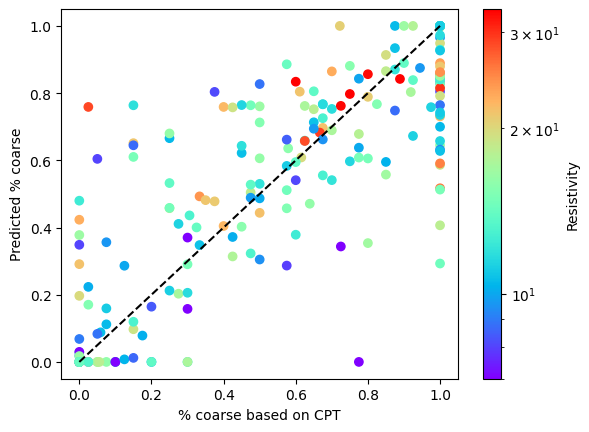

In [ ]:
### Make prediction
X_pred = np.copy(X_star)
X_pred = tf.cast(X_pred, dtype=tf.float32)
u_pred, f_pred = model.predict(X_pred)
X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model.predict(X_pred)
rhoc, rhof = u_pred[:,1]*(max_coarse-min_coarse)+min_coarse, u_pred[:,0]*(max_fine-min_fine)+min_fine
rhof = rhof.numpy()
rhoc = rhoc.numpy()
r = X_star[:,4]
pc_temp= (rhoc*rhof/r-rhoc)*1/(rhof-rhoc)
pc_temp = pc_temp.numpy()
pc_temp[r<rhof] = 0
pc_temp[r>rhoc]=1
error_u = np.linalg.norm(u_star-pc_temp,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

#U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
#Error = np.abs(u_star - U_pred)

plt.scatter( u_star, pc_temp, c = X_star[:,4:5], cmap = 'rainbow', norm=colors.LogNorm(vmin = 7, vmax = 33))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("% coarse based on CPT")
plt.ylabel("Predicted % coarse")
plt.colorbar(label = "Resistivity")

In [ ]:
pc_temp.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
# Predict Layer

In [ ]:
### Make prediction on depth layer

depth_layer = 2
ind = z==depth_layer
X_temp = X_all[ind]
nx, ny, nz = 316, 431, 40
nall = len(zgrid.flatten())
print(len(X_temp))
X_pred = np.copy(X_all)
#X_pred[:,4] = np.log(X_pred[:,4])
X_pred = tf.cast(X_pred, dtype=tf.float32)
X_pred = tf.cast(X_pred[z==depth_layer], dtype=tf.float32)
u_pred, f_pred = model.predict(X_pred)
temp = zgrid.flatten()[ind_grid]==depth_layer
ind_layer = ind_grid[temp]
pc, rho_coarse, rho_fine, pc_physics = np.ones(nall)*np.nan, np.ones(nall)*np.nan, np.ones(nall)*np.nan, np.ones(nall)*np.nan
pc[ind_layer] = u_pred[:,0]
rho_coarse[ind_layer] = u_pred[:,1]*(max_coarse-min_coarse)+min_coarse
rho_fine[ind_layer] = u_pred[:,0]*(max_fine-min_fine)+min_fine
rhoc, rhof = u_pred[:,1]*(max_coarse-min_coarse)+min_coarse, u_pred[:,0]*(max_fine-min_fine)+min_fine
rhof = rhof.numpy()
rhoc = rhoc.numpy()
r = X_temp[:,4]
pc_temp= (rhoc*rhof/r-rhoc)*1/(rhof-rhoc)
pc_temp[r < rhof] = 0
pc_temp[r>rhoc]=1
pc_physics[ind_layer] = pc_temp


pc = pc.reshape([nx, ny, nz])[:,:,depth_layer]
rho_coarse = rho_coarse.reshape([nx, ny, nz])[:,:,depth_layer]
rho_fine = rho_fine.reshape([nx, ny, nz])[:,:,depth_layer]
pc_physics = pc_physics.reshape([nx, ny, nz])[:,:,depth_layer]


123152


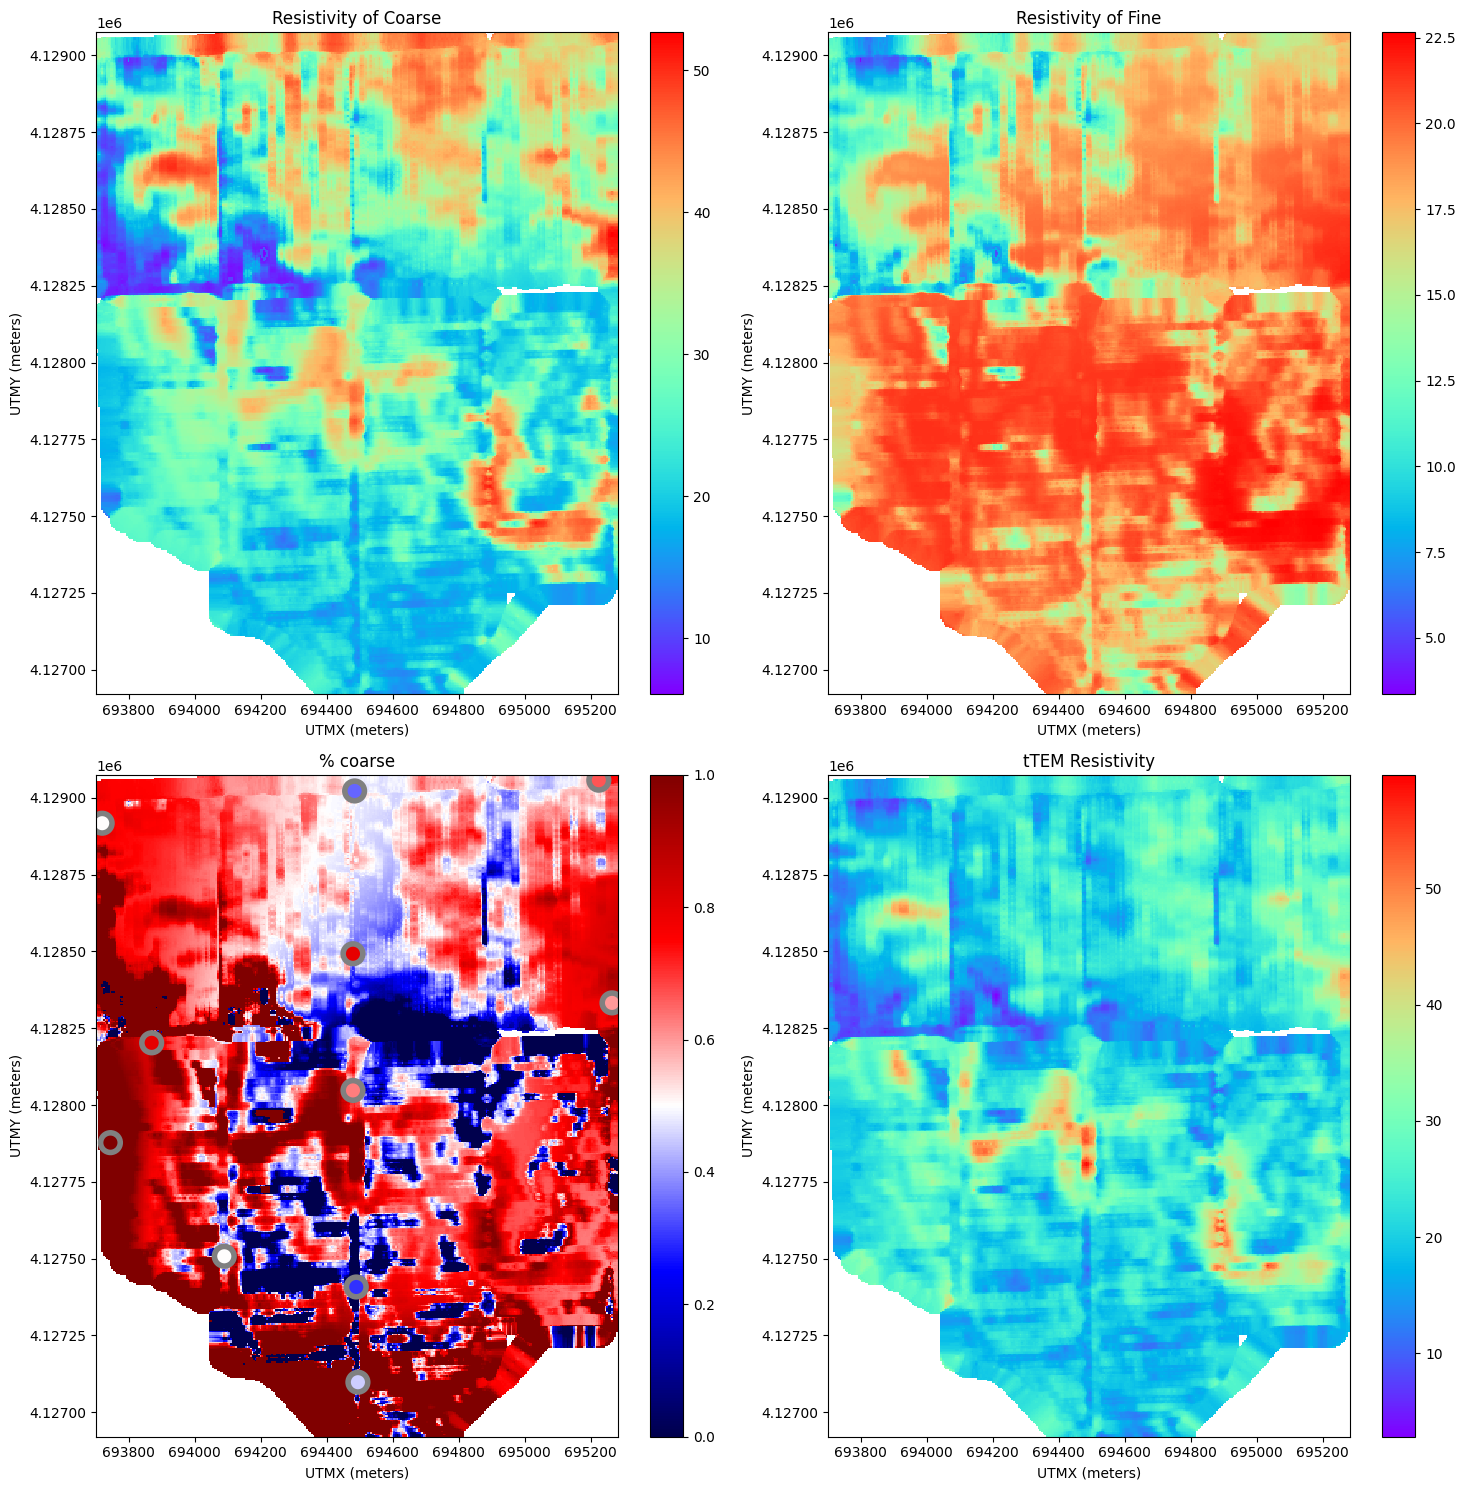

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(221)
plt.title("Resistivity of Coarse")
plt.pcolormesh(xgrid[:,:,depth_layer], ygrid[:,:,depth_layer],  rho_coarse, cmap = 'rainbow')
plt.xlabel("UTMX (meters)")
plt.ylabel("UTMY (meters)")
plt.colorbar()

plt.subplot(222)
plt.title("Resistivity of Fine")
plt.pcolormesh(xgrid[:,:,depth_layer], ygrid[:,:,depth_layer],  rho_fine, cmap = 'rainbow')
plt.xlabel("UTMX (meters)")
plt.ylabel("UTMY (meters)")
plt.colorbar()

plt.subplot(223)
plt.title("% coarse")
plt.pcolormesh(xgrid[:,:,depth_layer], ygrid[:,:,depth_layer], pc_physics, cmap = 'seismic')
ind_data_plot = z_data==depth_layer
ind_data_plot = ind_data_plot[:,0]
plt.scatter(x_data[ind_data_plot], y_data[ind_data_plot], c = data_pc[ind_data_plot], s = 200, edgecolors='grey', linewidths=4, cmap = 'seismic', vmin = 0, vmax = 1)
plt.xlabel("UTMX (meters)")
plt.ylabel("UTMY (meters)")
plt.colorbar()

plt.subplot(224)
plt.title("tTEM Resistivity")
plt.pcolormesh(xgrid[:,:,depth_layer], ygrid[:,:,depth_layer], resgrid[:,:,depth_layer], cmap = 'rainbow')
plt.xlabel("UTMX (meters)")
plt.ylabel("UTMY (meters)")
plt.colorbar()

plt.tight_layout()

In [ ]:
# Make prediction for entire grid

X_pred = tf.cast(X_all, dtype=tf.float32)
u_pred, f_pred = model.predict(X_pred)

In [ ]:
#save predictions

rhoc, rhof = u_pred[:,1]*(max_coarse-min_coarse)+min_coarse, u_pred[:,0]*(max_fine-min_fine)+min_fine
rhof = rhof.numpy()
rhoc = rhoc.numpy()
r = X_all[:,4]
pc_temp= (rhoc*rhof/r-rhoc)*1/(rhof-rhoc)
pc_temp[r<rhof] = 0
pc_temp[r>rhoc]=1
X_save = np.zeros([X_all.shape[0], 8])
X_save[:,0] = X_all[:,0]
X_save[:,1] = X_all[:,1]
X_save[:,2] = X_all[:,2]
X_save[:,3] = X_all[:,3]
X_save[:,4] = X_all[:,4]
X_save[:,5] = pc_temp
X_save[:,6] = rhoc
X_save[:,7] = rhof
np.save( "NN_output2.npy", X_save)

In [ ]:

X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred[:,0],2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))


Error u: 6.064650e-01


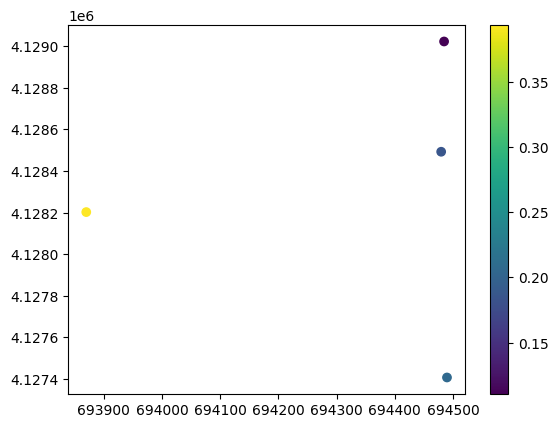

In [ ]:
depth_layer = 5
ind = z_data == depth_layer
u_pred_np = u_pred.numpy()  # Convert EagerTensor to NumPy array
u_pred_reshaped = u_pred_np[:, 0].reshape([220, 1])  # Reshape the NumPy array
f_u_pred = u_pred_reshaped[ind.reshape(-1)] # Reshape the boolean mask (ind) to a 1D array
plt.scatter(x_data[ind], y_data[ind], c = f_u_pred)
plt.colorbar()

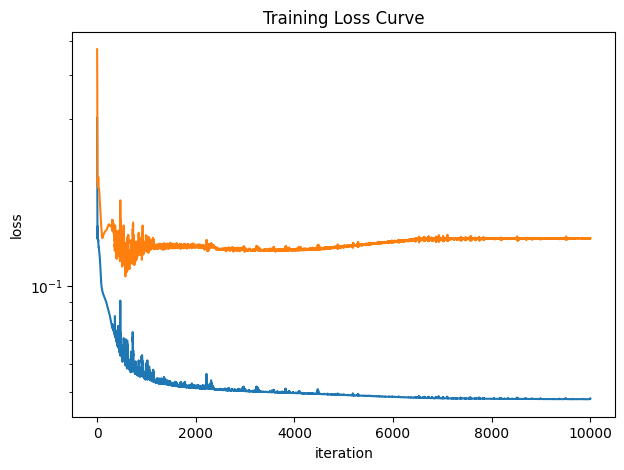

In [ ]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(it_list, loss_list)
ax.plot(it_list, test_loss_list)
ax.set_title('Training Loss Curve')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.show()

### Note it is common that you observe oscilations of loss curve along the training proceeds, this is due to
### Adam optimizer. To eliminate the oscilations you can try learning rate schedulers, i.e.
### tf.keras.optimizers.schedules.ExponentialDecay introduced in the training function (no guaranteed, osicilations
### can still be seen here). Or you can try L-BFGS optimizer (not implemented in this code)
### see https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/lbfgs_minimize